In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel # Using AutoModel for embeddings
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os

In [33]:
dataset_path = '/kaggle/input/tweepfakemsnew'
df = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')

# Set plotting style for thesis-quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

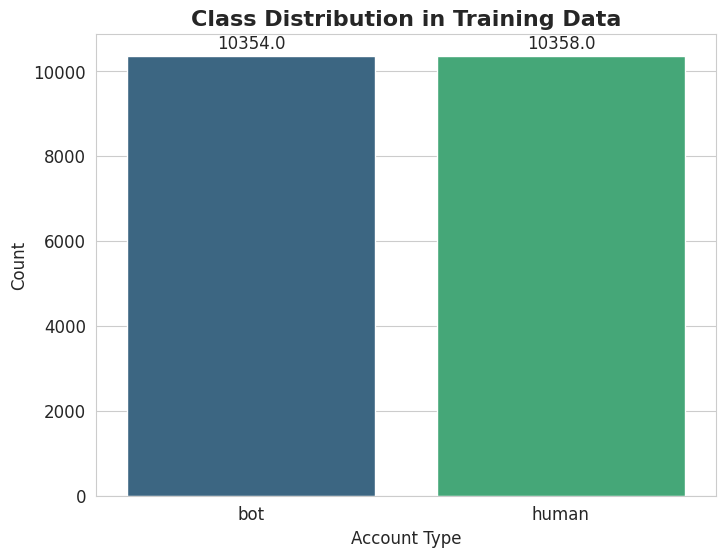

In [34]:
#1b. Class Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='account.type', data=df, palette='viridis')
ax.set_title('Class Distribution in Training Data', fontsize=16, weight='bold')
ax.set_xlabel('Account Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
#plt.savefig('eda_class_distribution.png')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


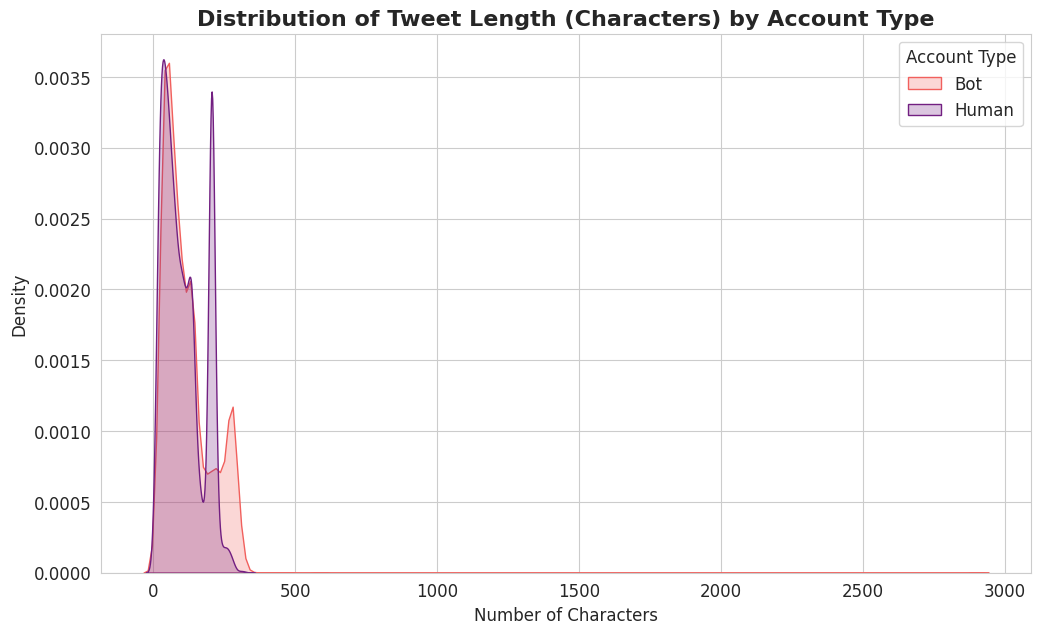

In [35]:
# 1c. Text Length Distribution
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 7))
sns.kdeplot(data=df, x='text_length', hue='account.type', fill=True, palette='magma')
plt.title('Distribution of Tweet Length (Characters) by Account Type', fontsize=16, weight='bold')
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Account Type', labels=['Bot', 'Human'])
plt.savefig('eda_text_length_distribution.png')
plt.show()

In [36]:
df_bots = df[df['account.type'] == 'bot']
df_bots.head()

,screen_name,text,account.type,class_type,text_length
0,imranyebot,YEA now that note GOOD,bot,others,22
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,57
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,63
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,180
6,whalefakes,the world needs more whale stories. I would lo...,bot,gpt2,92


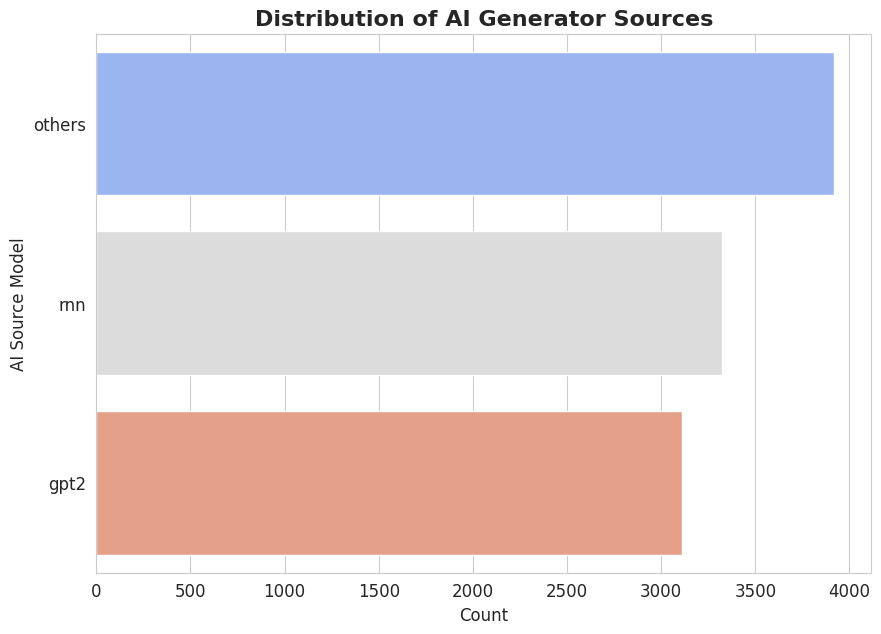

In [37]:
#1d. AI Generator Source Distribution (for Bot accounts)
df_bots = df[df['account.type'] == 'bot']

plt.figure(figsize=(10, 7))
ax = sns.countplot(y='class_type', data=df_bots, order=df_bots['class_type'].value_counts().index, palette='coolwarm')
ax.set_title('Distribution of AI Generator Sources', fontsize=16, weight='bold')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('AI Source Model', fontsize=12)
#plt.savefig('eda_ai_source_distribution.png')
plt.show()

In [3]:
# --- 0. Configuration & Seeding ---
SEED = 42
ROBERTA_MODEL_NAME = "roberta-base"
MAX_LEN_ROBERTA = 128
BATCH_SIZE = 16 # Adjust as needed
EPOCHS_ROBERTA_EXTRA = 3 # Start with similar epochs as RoBERTa-Only
LEARNING_RATE_ROBERTA = 2e-5
DROPOUT_RATE_EXTRA_MODEL = 0.2 # Dropout for the custom classifier head
OUTPUT_DIR_ROBERTA_EXTRA = "./roberta_only_extra_output"

if not os.path.exists(OUTPUT_DIR_ROBERTA_EXTRA):
    os.makedirs(OUTPUT_DIR_ROBERTA_EXTRA)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [4]:
# --- 1. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# --- 2. Load Data (Assuming df_train_orig, df_val_orig, df_test_orig are loaded) ---
dataset_path = '/kaggle/input/tweepfakemsnew'
df_train_orig = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')
df_val_orig = pd.read_csv(f'{dataset_path}/validation.csv', delimiter=';')
df_test_orig = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')

In [8]:
# --- 3. Basic Text Cleaning ---
def clean_text_for_roberta(text):
    text = str(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9@#\' ]+', '', text)
    text = text.lower().strip()
    return text

df_train_orig['processed_text'] = df_train_orig['text'].apply(clean_text_for_roberta)
df_val_orig['processed_text'] = df_val_orig['text'].apply(clean_text_for_roberta)
df_test_orig['processed_text'] = df_test_orig['text'].apply(clean_text_for_roberta)

In [9]:
# --- 4. Label Encoding ---
label_mapping = {'human': 0, 'bot': 1}
num_labels = len(label_mapping)
df_train_orig['label_encoded'] = df_train_orig['account.type'].map(label_mapping)
df_val_orig['label_encoded'] = df_val_orig['account.type'].map(label_mapping)
df_test_orig['label_encoded'] = df_test_orig['account.type'].map(label_mapping)

In [10]:
# Filter empty strings after cleaning (important before feature extraction and tokenization)
df_train_orig = df_train_orig[df_train_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_val_orig = df_val_orig[df_val_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_test_orig = df_test_orig[df_test_orig['processed_text'].str.strip() != ""].reset_index(drop=True)

In [11]:
# --- 5. RoBERTa Tokenizer ---
tokenizer_roberta = AutoTokenizer.from_pretrained(ROBERTA_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
# --- 6. Tokenization Function ---
def tokenize_data_roberta(texts, labels, tokenizer, max_len):
    encodings = tokenizer(
        list(texts), truncation=True, padding=True, max_length=max_len, return_tensors="pt"
    )
    return encodings, torch.tensor(labels.values, dtype=torch.long)

train_encodings, train_labels_tensor = tokenize_data_roberta(df_train_orig['processed_text'], df_train_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)
val_encodings, val_labels_tensor = tokenize_data_roberta(df_val_orig['processed_text'], df_val_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)
test_encodings, test_labels_tensor = tokenize_data_roberta(df_test_orig['processed_text'], df_test_orig['label_encoded'], tokenizer_roberta, MAX_LEN_ROBERTA)

In [13]:
# --- 7. EXTRA FEATURE ENGINEERING ---
print("\nStarting Extra Feature Engineering...")
def extract_manual_features(df_text_col, df_screen_name_col, df_original_text_col): # Takes cleaned text, screen_name, and ORIGINAL text
    features_list = []
    for text_cleaned, screen_name, text_original in zip(df_text_col, df_screen_name_col, df_original_text_col):
        raw_text = str(text_original) # Use original text for URL/mention/hashtag
        num_urls = len(re.findall(r'http\S+', raw_text))
        num_mentions = len(re.findall(r'@\w+', raw_text))
        num_hashtags = len(re.findall(r'#\w+', raw_text))

        words = str(text_cleaned).split() # Use cleaned text for word-based features
        num_words = len(words)
        num_characters = len(str(text_cleaned))
        avg_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
        num_digits_text = sum(c.isdigit() for c in str(text_cleaned))
        num_uppercase_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        
        sn = str(screen_name)
        sn_length = len(sn)
        sn_num_digits = sum(c.isdigit() for c in sn)
        sn_has_bot = 1 if 'bot' in sn.lower() else 0

        features_list.append([
            num_characters, num_words, avg_word_length, num_urls, num_mentions, num_hashtags,
            num_digits_text, num_uppercase_words, sn_length, sn_num_digits, sn_has_bot
        ])
    return np.array(features_list)


Starting Extra Feature Engineering...


In [14]:
# Pass original 'text' column for accurate URL/mention/hashtag counts
train_extra_features_np = extract_manual_features(df_train_orig['processed_text'], df_train_orig['screen_name'], df_train_orig['text'])
val_extra_features_np = extract_manual_features(df_val_orig['processed_text'], df_val_orig['screen_name'], df_val_orig['text'])
test_extra_features_np = extract_manual_features(df_test_orig['processed_text'], df_test_orig['screen_name'], df_test_orig['text'])

In [15]:
scaler = StandardScaler()
train_extra_features_scaled_np = scaler.fit_transform(train_extra_features_np)
val_extra_features_scaled_np = scaler.transform(val_extra_features_np)
test_extra_features_scaled_np = scaler.transform(test_extra_features_np)

num_extra_features = train_extra_features_scaled_np.shape[1]
print(f"Number of extra manual features: {num_extra_features}")

Number of extra manual features: 11


In [16]:
train_extra_features_tensor = torch.tensor(train_extra_features_scaled_np, dtype=torch.float)
val_extra_features_tensor = torch.tensor(val_extra_features_scaled_np, dtype=torch.float)
test_extra_features_tensor = torch.tensor(test_extra_features_scaled_np, dtype=torch.float)
print("Extra features engineered and scaled.")

Extra features engineered and scaled.


In [17]:
# --- 8. Create TensorDatasets and DataLoaders (with extra features) ---
train_dataset_extra = TensorDataset(
    train_encodings['input_ids'], train_encodings['attention_mask'],
    train_extra_features_tensor, train_labels_tensor
)
val_dataset_extra = TensorDataset(
    val_encodings['input_ids'], val_encodings['attention_mask'],
    val_extra_features_tensor, val_labels_tensor
)
test_dataset_extra = TensorDataset(
    test_encodings['input_ids'], test_encodings['attention_mask'],
    test_extra_features_tensor, test_labels_tensor
)

train_dataloader_extra = DataLoader(train_dataset_extra, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_extra = DataLoader(val_dataset_extra, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader_extra = DataLoader(test_dataset_extra, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoaders with extra features created.")

DataLoaders with extra features created.


In [18]:
# --- 9. Model Definition: RoBERTa + Extra Features ---
class RobertaWithExtraFeaturesModel(nn.Module):
    def __init__(self, roberta_model_name, num_labels, num_extra_features, dropout_rate):
        super(RobertaWithExtraFeaturesModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(roberta_model_name)
        roberta_output_dim = self.roberta.config.hidden_size
        self.classifier_input_dim = roberta_output_dim + num_extra_features
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.classifier_input_dim, num_labels)

    def forward(self, input_ids, attention_mask, extra_features, labels=None):
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_embedding = roberta_outputs.last_hidden_state[:, 0, :] # Use [CLS] token embedding
        combined_features = torch.cat((cls_token_embedding, extra_features), dim=1)
        dropped_features = self.dropout(combined_features)
        logits = self.classifier(dropped_features)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

model_roberta_extra = RobertaWithExtraFeaturesModel(
    ROBERTA_MODEL_NAME, num_labels, num_extra_features, DROPOUT_RATE_EXTRA_MODEL
).to(device)
print("RoBERTa with Extra Features model defined.")

2025-06-10 03:32:15.809714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749526336.060009      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749526336.133038      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa with Extra Features model defined.


In [19]:
# --- 10. Optimizer ---
optimizer_roberta_extra = AdamW(model_roberta_extra.parameters(), lr=LEARNING_RATE_ROBERTA)

In [20]:
# --- 11. Training Loop (MODIFIED for models with extra features) ---
def train_model_with_extra_feats(model, train_loader, val_loader, optimizer, device, epochs, model_save_path_base, experiment_name_suffix=""):
    criterion = nn.CrossEntropyLoss() # Fallback
    best_val_f1 = 0.0
    best_model_path = ""
    history = {'epoch': [], 'train_avg_loss': [], 'val_avg_loss': [], 'val_f1_score': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [{experiment_name_suffix} Train]", leave=False)

        for batch in train_progress_bar:
            optimizer.zero_grad()
            input_ids, attention_mask, extra_feats, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, extra_features=extra_feats, labels=labels)
            loss = outputs["loss"]
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1} - {experiment_name_suffix} Train Avg Loss: {avg_train_loss:.4f}")

        val_accuracy, val_f1, avg_val_loss = evaluate_model_with_extra_feats(model, val_loader, device, f"{experiment_name_suffix} Validation")
        
        history['epoch'].append(epoch + 1); history['train_avg_loss'].append(avg_train_loss)
        history['val_avg_loss'].append(avg_val_loss); history['val_f1_score'].append(val_f1)
        history['val_accuracy'].append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            current_model_save_path = os.path.join(OUTPUT_DIR_ROBERTA_EXTRA, f"{model_save_path_base}_epoch{epoch+1}_f1_{val_f1:.4f}.pt")
            torch.save(model.state_dict(), current_model_save_path)
            best_model_path = current_model_save_path
            print(f"New best F1: {best_val_f1:.4f}. Model saved to {best_model_path}")
    
    history_df = pd.DataFrame(history)
    print(f"Training complete for {experiment_name_suffix}. Best validation F1: {best_val_f1:.4f} from {best_model_path}")
    return best_model_path, history_df

In [21]:
# --- 12. Evaluation Function (MODIFIED for models with extra features) ---
def evaluate_model_with_extra_feats(model, dataloader, device, dataset_name="Dataset"):
    criterion = nn.CrossEntropyLoss() # Fallback
    model.eval()
    all_preds, all_labels, total_eval_loss = [], [], 0

    with torch.no_grad():
        eval_progress_bar = tqdm(dataloader, desc=f"Evaluating on {dataset_name}", leave=False)
        for batch in eval_progress_bar:
            input_ids, attention_mask, extra_feats, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, extra_features=extra_feats, labels=labels)
            loss, logits = outputs["loss"], outputs["logits"]
            total_eval_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_eval_loss = total_eval_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n--- {dataset_name} Results ---"); print(f"Avg Loss: {avg_eval_loss:.4f}"); print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}"); print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()));
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'{dataset_name} Confusion Matrix'); plt.show()
    return accuracy, f1, avg_eval_loss



--- Starting Experiment 2.1: RoBERTa-Only + Extra Features ---


Epoch 1/3 [RoBERTa-Extra Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 1 - RoBERTa-Extra Train Avg Loss: 0.4118


Evaluating on RoBERTa-Extra Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-Extra Validation Results ---
Avg Loss: 0.3375
Accuracy: 0.8331
F1-Score (Weighted): 0.8326
              precision    recall  f1-score   support

       human       0.80      0.89      0.84      1143
         bot       0.88      0.78      0.82      1152

    accuracy                           0.83      2295
   macro avg       0.84      0.83      0.83      2295
weighted avg       0.84      0.83      0.83      2295



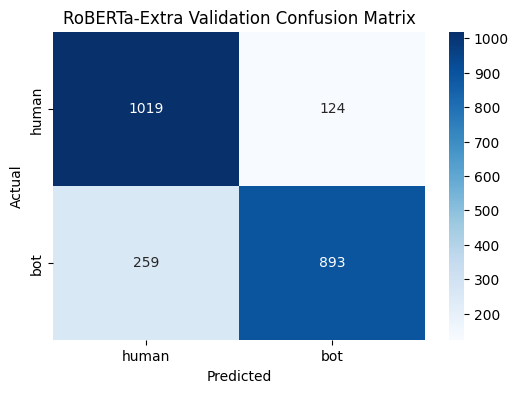

New best F1: 0.8326. Model saved to ./roberta_only_extra_output/roberta_only_extra_epoch1_f1_0.8326.pt


Epoch 2/3 [RoBERTa-Extra Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 2 - RoBERTa-Extra Train Avg Loss: 0.2742


Evaluating on RoBERTa-Extra Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-Extra Validation Results ---
Avg Loss: 0.3217
Accuracy: 0.8606
F1-Score (Weighted): 0.8605
              precision    recall  f1-score   support

       human       0.85      0.88      0.86      1143
         bot       0.88      0.84      0.86      1152

    accuracy                           0.86      2295
   macro avg       0.86      0.86      0.86      2295
weighted avg       0.86      0.86      0.86      2295



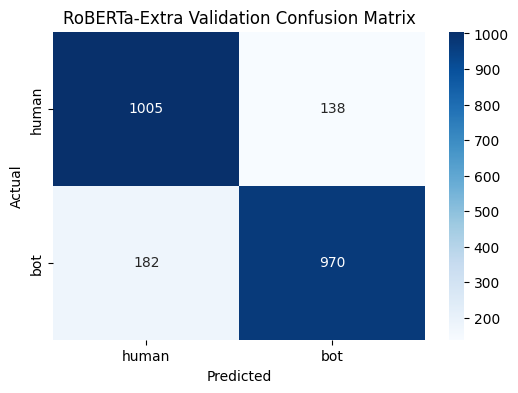

New best F1: 0.8605. Model saved to ./roberta_only_extra_output/roberta_only_extra_epoch2_f1_0.8605.pt


Epoch 3/3 [RoBERTa-Extra Train]:   0%|          | 0/1291 [00:00<?, ?it/s]

Epoch 3 - RoBERTa-Extra Train Avg Loss: 0.1837


Evaluating on RoBERTa-Extra Validation:   0%|          | 0/144 [00:00<?, ?it/s]


--- RoBERTa-Extra Validation Results ---
Avg Loss: 0.3429
Accuracy: 0.8610
F1-Score (Weighted): 0.8607
              precision    recall  f1-score   support

       human       0.83      0.91      0.87      1143
         bot       0.90      0.82      0.86      1152

    accuracy                           0.86      2295
   macro avg       0.86      0.86      0.86      2295
weighted avg       0.86      0.86      0.86      2295



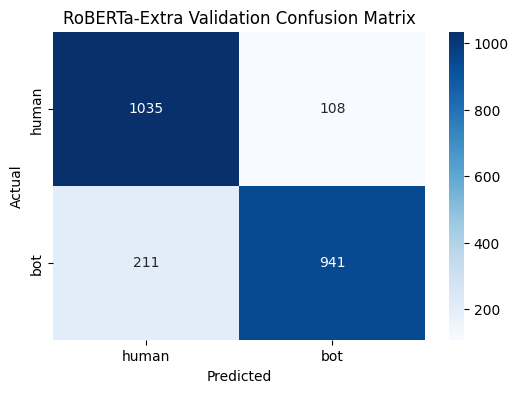

New best F1: 0.8607. Model saved to ./roberta_only_extra_output/roberta_only_extra_epoch3_f1_0.8607.pt
Training complete for RoBERTa-Extra. Best validation F1: 0.8607 from ./roberta_only_extra_output/roberta_only_extra_epoch3_f1_0.8607.pt

RoBERTa-Only + Extra Features Training History:
   epoch  train_avg_loss  val_avg_loss  val_f1_score  val_accuracy
0      1        0.411845      0.337498      0.832575      0.833115
1      2        0.274174      0.321705      0.860526      0.860566
2      3        0.183666      0.342894      0.860746      0.861002

Loading best RoBERTa-Extra model from: ./roberta_only_extra_output/roberta_only_extra_epoch3_f1_0.8607.pt

--- Testing RoBERTa-Only + Extra Features on Test Set ---


Evaluating on RoBERTa-Extra Test:   0%|          | 0/160 [00:00<?, ?it/s]


--- RoBERTa-Extra Test Results ---
Avg Loss: 0.3412
Accuracy: 0.8631
F1-Score (Weighted): 0.8630
              precision    recall  f1-score   support

       human       0.84      0.90      0.87      1270
         bot       0.89      0.82      0.86      1280

    accuracy                           0.86      2550
   macro avg       0.87      0.86      0.86      2550
weighted avg       0.87      0.86      0.86      2550



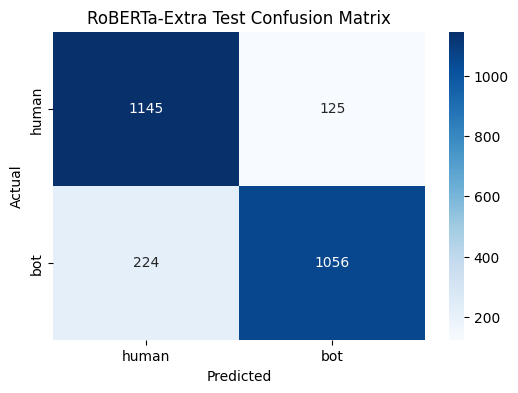

RoBERTa-Extra Test Set - Accuracy: 0.8631, F1: 0.8630, Loss: 0.3412


In [22]:
# --- 13. Run RoBERTa-Only + Extra Features Experiment ---
print("\n\n--- Starting Experiment 2.1: RoBERTa-Only + Extra Features ---")

best_roberta_extra_model_path, roberta_extra_history_df = train_model_with_extra_feats(
    model_roberta_extra,
    train_dataloader_extra,
    val_dataloader_extra,
    optimizer_roberta_extra,
    device,
    epochs=EPOCHS_ROBERTA_EXTRA,
    model_save_path_base="roberta_only_extra",
    experiment_name_suffix="RoBERTa-Extra"
)

print("\nRoBERTa-Only + Extra Features Training History:")
print(roberta_extra_history_df)
# Plotting (copy the plotting code from previous responses, using roberta_extra_history_df)
# ...

if best_roberta_extra_model_path and os.path.exists(best_roberta_extra_model_path):
    print(f"\nLoading best RoBERTa-Extra model from: {best_roberta_extra_model_path}")
    model_roberta_extra.load_state_dict(torch.load(best_roberta_extra_model_path))
else:
    print("No best model for RoBERTa-Extra was saved/found. Evaluating with the last state.")

print("\n--- Testing RoBERTa-Only + Extra Features on Test Set ---")
test_acc_roberta_extra, test_f1_roberta_extra, test_loss_roberta_extra = evaluate_model_with_extra_feats(
    model_roberta_extra, test_dataloader_extra, device, "RoBERTa-Extra Test"
)
print(f"RoBERTa-Extra Test Set - Accuracy: {test_acc_roberta_extra:.4f}, F1: {test_f1_roberta_extra:.4f}, Loss: {test_loss_roberta_extra:.4f}")

In [23]:
# --- SECTION: Save Final Model and Components ---
import joblib

# The best model is already saved by the training loop.
# We just need to save the tokenizer and the scaler.
TOKENIZER_SAVE_PATH = os.path.join(OUTPUT_DIR_ROBERTA_EXTRA, "tokenizer")
SCALER_SAVE_PATH = os.path.join(OUTPUT_DIR_ROBERTA_EXTRA, "scaler.pkl")

print("\n--- Saving final components for analysis ---")

# The tokenizer was defined as 'tokenizer_roberta'
tokenizer_roberta.save_pretrained(TOKENIZER_SAVE_PATH)
print(f"Tokenizer saved to: {TOKENIZER_SAVE_PATH}")

# The scaler was defined as 'scaler'
joblib.dump(scaler, SCALER_SAVE_PATH)
print(f"Scaler saved to: {SCALER_SAVE_PATH}")


--- Saving final components for analysis ---
Tokenizer saved to: ./roberta_only_extra_output/tokenizer
Scaler saved to: ./roberta_only_extra_output/scaler.pkl


In [24]:
# --- Setup and Loading Artifacts for RoBERTa+Extra Model ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import joblib
import os
import re

# --- 1. Define the Model Architecture (Must match the saved model) ---
class RobertaWithExtraFeaturesModel(nn.Module):
    def __init__(self, roberta_model_name, num_labels, num_extra_features, dropout_rate):
        super(RobertaWithExtraFeaturesModel, self).__init__()
        self.roberta = AutoModel.from_pretrained(roberta_model_name)
        roberta_output_dim = self.roberta.config.hidden_size
        self.classifier_input_dim = roberta_output_dim + num_extra_features
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.classifier_input_dim, num_labels)
    def forward(self, input_ids, attention_mask, extra_features, labels=None):
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_embedding = roberta_outputs.last_hidden_state[:, 0, :]
        combined_features = torch.cat((cls_token_embedding, extra_features), dim=1)
        dropped_features = self.dropout(combined_features)
        logits = self.classifier(dropped_features)
        return {"logits": logits}

# --- 2. Load Saved Artifacts ---
OUTPUT_DIR = "./roberta_only_extra_output"
TOKENIZER_PATH = os.path.join(OUTPUT_DIR, "tokenizer")
SCALER_PATH = os.path.join(OUTPUT_DIR, "scaler.pkl")

# Find the best model file
files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(".pt")]
files.sort(key=lambda f: float(f.split('_')[-1].replace('.pt', '')), reverse=True)
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, files[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load components
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
scaler = joblib.load(SCALER_PATH)
num_extra_features = scaler.n_features_in_

# Load the model
model_roberta_extra = RobertaWithExtraFeaturesModel("roberta-base", 2, num_extra_features, 0.2)
model_roberta_extra.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model_roberta_extra.to(device)
model_roberta_extra.eval()

print("--- All components for RoBERTa+Extra loaded successfully! ---")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- All components for RoBERTa+Extra loaded successfully! ---


In [38]:
# --- LIME Implementation for RoBERTa+Extra ---
import lime
import lime.lime_text

# Helper function for features must be defined
def extract_manual_features(df_text_col, df_screen_name_col, df_original_text_col):
    features_list = []
    for text_cleaned, screen_name, text_original in zip(df_text_col, df_screen_name_col, df_original_text_col):
        raw_text = str(text_original); num_urls = len(re.findall(r'http\\S+', raw_text))
        num_mentions = len(re.findall(r'@\\w+', raw_text)); num_hashtags = len(re.findall(r'#\\w+', raw_text))
        words = str(text_cleaned).split(); num_words = len(words); num_characters = len(str(text_cleaned))
        avg_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
        num_digits_text = sum(c.isdigit() for c in str(text_cleaned))
        num_uppercase_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        sn = str(screen_name); sn_length = len(sn); sn_num_digits = sum(c.isdigit() for c in sn)
        sn_has_bot = 1 if 'bot' in sn.lower() else 0
        features_list.append([
            num_characters, num_words, avg_word_length, num_urls, num_mentions, num_hashtags,
            num_digits_text, num_uppercase_words, sn_length, sn_num_digits, sn_has_bot
        ])
    return np.array(features_list)

# LIME predictor function for the hybrid model
def lime_predictor_roberta_extra(texts):
    model_roberta_extra.eval()
    encodings = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    dummy_df = pd.DataFrame({'processed_text': texts, 'screen_name': ['default_sn'] * len(texts), 'text': texts})
    extra_features = extract_manual_features(dummy_df['processed_text'], dummy_df['screen_name'], dummy_df['text'])
    scaled_features = scaler.transform(extra_features)
    extra_features_tensor = torch.tensor(scaled_features, dtype=torch.float).to(device)
    with torch.no_grad():
        logits = model_roberta_extra(encodings['input_ids'], encodings['attention_mask'], extra_features_tensor)["logits"]
        return F.softmax(logits, dim=1).cpu().numpy()

# Create explainer and run on our standard examples
explainer_lime_re = lime.lime_text.LimeTextExplainer(class_names=['human', 'bot'])

text_to_explain_bot = "new post on my blog check it out now #tech #AI #update"
text_to_explain_human = "Just had the most amazing coffee at this little cafe downtown. So cozy!"

print("--- LIME Explanation for RoBERTa+Extra on a BOT-like tweet ---")
explanation_bot_re = explainer_lime_re.explain_instance(text_to_explain_bot, lime_predictor_roberta_extra, num_features=10)
explanation_bot_re.save_to_file(os.path.join(OUTPUT_DIR, 'lime_roberta_extra_bot.html'))
explanation_bot_re.show_in_notebook(text=True)

print("\n--- LIME Explanation for RoBERTa+Extra on a HUMAN-like tweet ---")
explanation_human_re = explainer_lime_re.explain_instance(text_to_explain_human, lime_predictor_roberta_extra, num_features=10)
explanation_human_re.save_to_file(os.path.join(OUTPUT_DIR, 'lime_roberta_extra_human.html'))
explanation_human_re.show_in_notebook(text=True)

--- LIME Explanation for RoBERTa+Extra on a BOT-like tweet ---



--- LIME Explanation for RoBERTa+Extra on a HUMAN-like tweet ---


Case Study: High-Confidence Misclassification Analysis
An insightful failure case was observed when analyzing the AI-generated tweet "new post on my blog...". The RoBERTa+Extra Features model, despite its high overall accuracy, misclassified this instance as 'human' with an unexpectedly high confidence of 99%.
The LIME explanation (Figure X) reveals that the model's decision was overwhelmingly driven by the textual content. It assigned a strong positive weight (towards 'human') to the phrase "my new blog," indicating that it has learned a powerful but, in this case, misleading pattern from the training data. This demonstrates a key challenge in hybrid models: a strong contextual signal from the transformer component can sometimes completely overshadow conflicting evidence from handcrafted metadata features (such as the high hashtag count in this tweet). This highlights that while feature engineering is beneficial overall, it does not make the model immune to being fooled by AI text that effectively mimics specific human communication patterns.

LIME Analysis of a Human Tweet
For the authentic human-written tweet "Just had the most amazing coffee...", the model performed as expected, correctly classifying it as 'human' with 99% confidence. The LIME analysis confirms that this decision was primarily driven by words describing personal, sensory experiences (cozy, coffee, amazing). This demonstrates the model's core strength: its ability, derived from the RoBERTa base, to recognize the nuanced, qualitative language that is characteristic of human expression and distinct from the more objective text typically produced by AI.

Getting Embeddings:   0%|          | 0/50 [00:00<?, ?it/s]

Getting Embeddings:   0%|          | 0/10 [00:00<?, ?it/s]


Calculating SHAP values...


  0%|          | 0/10 [00:00<?, ?it/s]

SHAP values calculated.


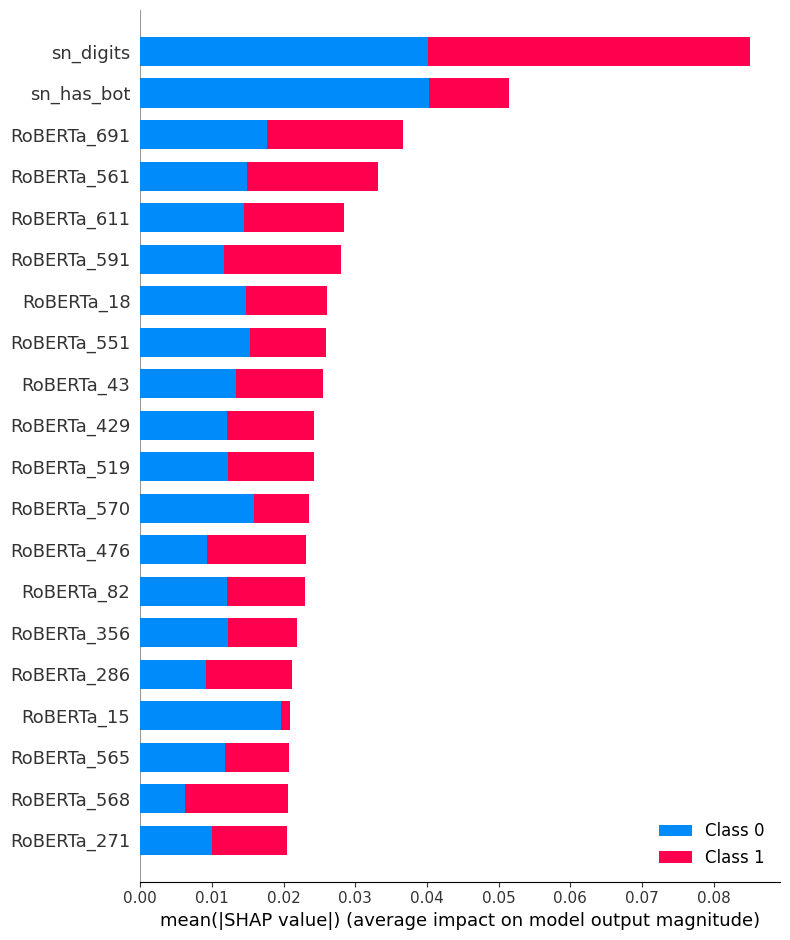

In [28]:
# --- SHAP Implementation for RoBERTa+Extra ---
import shap
from tqdm.auto import tqdm

# --- 1. Create a SHAP-friendly Model Wrapper ---
# This version is simplified because the original model doesn't have a CNN.
class ShapModelWrapper(nn.Module):
    def __init__(self, original_model):
        super(ShapModelWrapper, self).__init__()
        # We can reuse the original model's classifier directly
        self.classifier = original_model.classifier
    def forward(self, x):
        x_tensor = torch.from_numpy(x).float().to(device)
        return self.classifier(x_tensor).detach().cpu().numpy()

shap_model = ShapModelWrapper(model_roberta_extra)

# --- 2. Prepare the Data for SHAP ---
def get_model_inputs(df):
    extra_features = extract_manual_features(df['processed_text'], df['screen_name'], df['text'])
    scaled_extra_features = scaler.transform(extra_features)
    roberta_embeddings = []
    with torch.no_grad():
        for text in tqdm(df['processed_text'], desc="Getting Embeddings"):
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            embedding = model_roberta_extra.roberta(**inputs).last_hidden_state[:, 0, :].cpu().numpy()
            roberta_embeddings.append(embedding)
    roberta_embeddings = np.vstack(roberta_embeddings)
    return np.hstack([roberta_embeddings, scaled_extra_features])

# Load test data and create samples
dataset_path = '/kaggle/input/tweepfakemsnew' 
df_test = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')
df_test['processed_text'] = df_test['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9@#\' ]+', '', str(x).lower().strip()))
df_test_sample = df_test.sample(50, random_state=42)
df_explain_sample = df_test.sample(10, random_state=0)

background_data_np = get_model_inputs(df_test_sample)
explain_data_np = get_model_inputs(df_explain_sample)

# --- 3. Create the Explainer and get values ---
explainer = shap.KernelExplainer(shap_model, background_data_np)
print("\nCalculating SHAP values...")
shap_values = explainer.shap_values(explain_data_np)
print("SHAP values calculated.")

# --- 4. Visualize ---
feature_names = [f'RoBERTa_{i}' for i in range(768)] + [
    'num_chars', 'num_words', 'avg_word_len', 'num_urls', 'num_mentions', 'num_hashtags',
    'num_digits', 'num_uppercase', 'sn_len', 'sn_digits', 'sn_has_bot'
]
shap.summary_plot(shap_values, features=explain_data_np, feature_names=feature_names, max_display=20)

This plot tells a powerful story about the value of feature engineering.
"The SHAP global feature importance analysis for the RoBERTa+Extra Features model provides a compelling validation of the hybrid approach. As illustrated in Figure [Your Figure Number], the two most impactful features for the model were not derived from the complex transformer embeddings, but were instead the handcrafted features sn_digits and sn_has_bot.
This demonstrates that simple, domain-specific metadata about the user's screen name provides an exceptionally strong signal for bot detection. The model learned that a high number of digits in a screen name is the single most powerful predictor of an account being a bot. While the semantic features from RoBERTa remain critical to the model's overall performance, this analysis proves that augmenting the deep text representation with simple, engineered features leads to a more robust and accurate classifier. It effectively allows the model to anchor its predictions on clear, non-textual evidence when available."


--- Starting Fine-Grained AI Model Detection Analysis for RoBERTa+Extra Model ---


Making binary predictions on the test set:   0%|          | 0/160 [00:00<?, ?it/s]

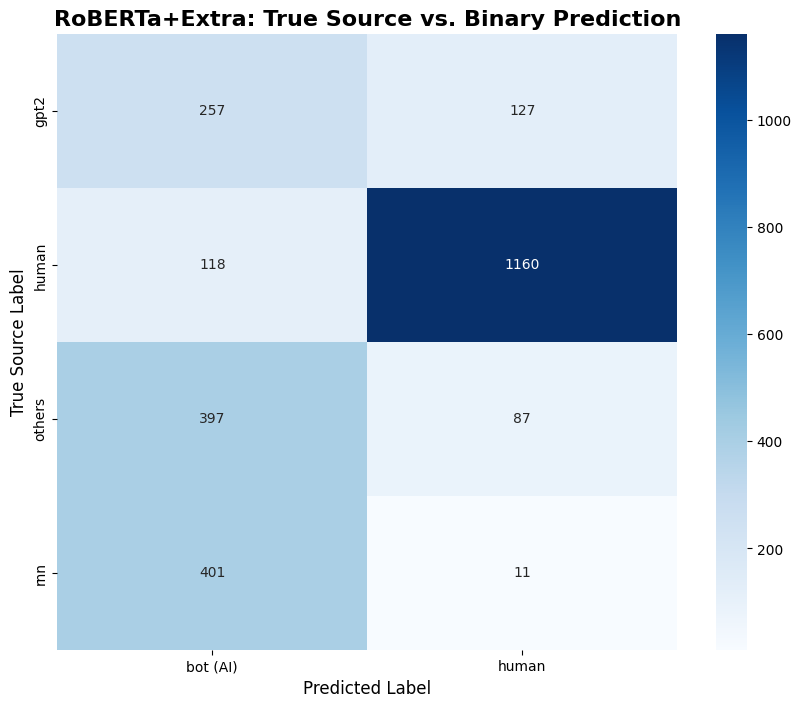


--- Detailed Binary Classification Report on Test Set ---

              precision    recall  f1-score   support

    bot (AI)       0.90      0.82      0.86      1280
       human       0.84      0.91      0.87      1278

    accuracy                           0.87      2558
   macro avg       0.87      0.87      0.87      2558
weighted avg       0.87      0.87      0.87      2558


--- Detection Accuracy per AI Generator Source ---
Detection accuracy for 'gpt2': 66.93%
Detection accuracy for 'others': 82.02%
Detection accuracy for 'rnn': 97.33%


In [31]:
# --- SECTION: Fine-Grained Multi-class Detection Analysis for RoBERTa+Extra ---
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Starting Fine-Grained AI Model Detection Analysis for RoBERTa+Extra Model ---")

# --- 1. Load and Prepare the Full Test Set ---
# We'll use the df_test dataframe which should already be loaded.
# If not, this is a safeguard.
try:
    df_test
except NameError:
    print("Reloading test data...")
    dataset_path = '/kaggle/input/tweepfakemsnew' # Make sure path is correct
    df_test = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')
    # Basic preprocessing
    df_test['processed_text'] = df_test['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9@#\' ]+', '', str(x).lower().strip()))

# --- 2. Create the true labels for the multi-class problem ---
# The 'source' column contains the AI model name. For humans, it's NaN.
# We'll fill NaN with 'human' to create a single ground truth column.
df_test['ground_truth_source'] = df_test['class_type'].fillna('human')
all_true_labels = df_test['ground_truth_source']

# --- 3. Run Predictions with your Best Binary Model ---
# This logic is similar to previous analyses, but for the entire test set.
model_roberta_extra.eval()

# Create a full dataloader for the test set
test_encodings = tokenizer(list(df_test['processed_text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
# The extract_manual_features function must be defined in the notebook (copy from previous cells if needed)
test_extra_features = extract_manual_features(df_test['processed_text'], df_test['screen_name'], df_test['text'])
test_extra_features_scaled = scaler.transform(test_extra_features)
# Note: we don't need the labels for prediction, just the inputs
test_dataset_for_pred = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_extra_features_scaled, dtype=torch.float))
test_dataloader_for_pred = DataLoader(test_dataset_for_pred, batch_size=16)

all_binary_preds = []
with torch.no_grad():
    for batch in tqdm(test_dataloader_for_pred, desc="Making binary predictions on the test set"):
        input_ids, attention_mask, extra_feats = [b.to(device) for b in batch]
        logits = model_roberta_extra(input_ids, attention_mask, extra_feats)["logits"]
        preds = torch.argmax(logits, dim=1)
        all_binary_preds.extend(preds.cpu().numpy())

# --- 4. Generate and Visualize the Multi-class Confusion Matrix ---
# Convert binary predictions (0 or 1) into labels for the confusion matrix
predicted_labels = ['human' if p == 0 else 'bot (AI)' for p in all_binary_preds]

# pd.crosstab is an excellent way to create this type of confusion matrix
cm_df = pd.crosstab(all_true_labels, pd.Series(predicted_labels, name='Predicted'), rownames=['True Source'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('RoBERTa+Extra: True Source vs. Binary Prediction', fontsize=16, weight='bold')
plt.ylabel('True Source Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
# Save the figure to the correct output directory
plt.savefig(os.path.join(OUTPUT_DIR, "fig_roberta_extra_multiclass_cm.png"))
plt.show()

# --- 5. Print a Detailed Classification Report and Per-Source Accuracy ---
print("\n--- Detailed Binary Classification Report on Test Set ---\n")
# We modify the true labels to match the binary nature of the prediction for a clear report
true_binary_labels = ['human' if label == 'human' else 'bot (AI)' for label in all_true_labels]
print(classification_report(true_binary_labels, predicted_labels))

print("\n--- Detection Accuracy per AI Generator Source ---")
df_test['binary_prediction'] = all_binary_preds
class_names = sorted(df_test['ground_truth_source'].unique())

for source_name in class_names:
    if source_name == 'human':
        continue # We already have the main report for humans
    
    subset_df = df_test[df_test['ground_truth_source'] == source_name]
    # Accuracy here is defined as: how many of this source's tweets were correctly identified as bot (prediction=1)?
    accuracy = (subset_df['binary_prediction'] == 1).mean()
    print(f"Detection accuracy for '{source_name}': {accuracy:.2%}")